<a href="https://colab.research.google.com/github/Daria-Lytvynenko/ML_course/blob/main/HW_NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

Mounted at /content/drive


In [2]:
df = pd.read_csv('drive/MyDrive/ML_course/tweet_sentiment_train.csv/train.csv')

In [3]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
df.dropna(inplace=True)

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [6]:
df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


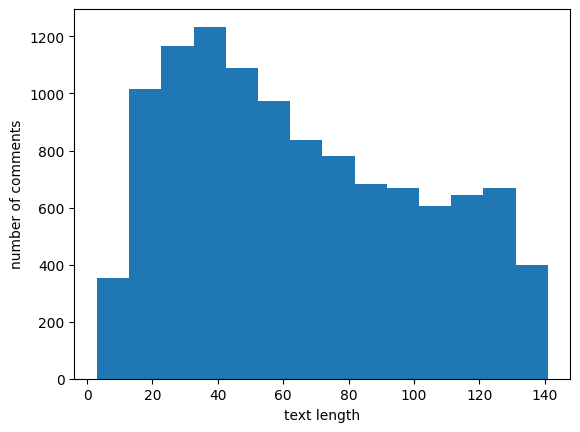

In [7]:
plt.hist(df[df.sentiment=='neutral']['text'].str.len(), bins=14)
plt.xlabel('text length')
plt.ylabel('number of comments');

Text(0.5, 1.0, 'negative')

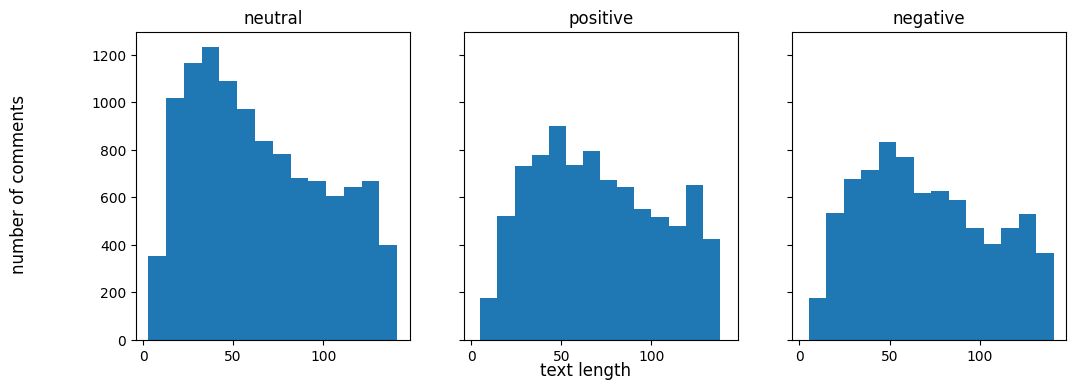

In [8]:
fig, ax=plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True, sharey=True)
fig.supxlabel('text length')
fig.supylabel('number of comments')
ax[0].hist(df[df.sentiment=='neutral']['text'].str.len(), bins=14)
ax[0].set_title('neutral')
ax[1].hist(df[df.sentiment=='positive']['text'].str.len(), bins=14)
ax[1].set_title('positive')
ax[2].hist(df[df.sentiment=='negative']['text'].str.len(), bins=14)
ax[2].set_title('negative')

Найбільше коментарів, що містять близько 40 символів, розподіл зміщений вліво. Якщо окремо дивитись по типу коментарів, то видно, для всіх груп розподіл подібний.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [9]:
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

In [10]:
import nltk

In [11]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
detector=PunktSentenceTokenizer()

In [13]:
vect=CountVectorizer()
vect_fit=vect.fit(df.text)

In [14]:
vect.get_feature_names_out().shape

(26439,)

In [15]:
vectors=vect.transform(df.text)

In [16]:
stemmer=SnowballStemmer(language='english')

In [17]:
nltk.download('stopwords')
english_stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [84]:
def tokenize(text):
  return [stemmer.stem(word) for word in word_tokenize(text) if word not in english_stopwords]

In [19]:
vectorizer=CountVectorizer(lowercase=True,
                           tokenizer=tokenize,
                           stop_words=english_stopwords,
                           max_features=1000)


In [20]:
vectorizer.fit(df['selected_text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x7b77bb95db20>)

In [21]:
inputs=vectorizer.transform(df['selected_text'])

In [22]:
inputs.shape

(27480, 1000)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [23]:
target=df.iloc[:,-1].name

In [24]:
train_idx, test_idx=train_test_split(range(inputs.shape[0]), test_size=0.3, random_state=42)

In [25]:
X_train_bow=inputs[train_idx]
X_test_bow=inputs[test_idx]
y_train=df.iloc[train_idx, -1]
y_test=df.iloc[test_idx, -1]

In [26]:
logreg=LogisticRegression(solver='saga', penalty='l1')

In [27]:
logreg.fit(X_train_bow, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(penalty='l1', solver='saga')

In [28]:
y_pred_train=logreg.predict(X_train_bow)

In [29]:
accuracy_score(y_train, y_pred_train)

0.7891453524641298

In [30]:
f1_score(y_train, y_pred_train, average='weighted')

0.7885441714135176

In [31]:
confusion_matrix(y_train, y_pred_train)

array([[3964, 1085,  376],
       [ 639, 6646,  489],
       [ 643,  824, 4570]])

In [32]:
y_pred=logreg.predict(X_test_bow)

In [33]:
accuracy_score(y_test, y_pred)

0.7800824842309558

In [34]:
f1_score(y_test, y_pred, average='weighted')

0.7797064287291002

In [35]:
confusion_matrix(y_test, y_pred)

array([[1712,  461,  183],
       [ 326, 2797,  220],
       [ 284,  339, 1922]])

In [36]:
tree=DecisionTreeClassifier(splitter='best', random_state=42, max_depth=1000)

In [37]:
tree.fit(X_train_bow, y_train)
tree_pred=tree.predict(X_test_bow)

In [38]:
accuracy_score(y_test, tree_pred)

0.7071809801067444

In [39]:
f1_score(y_test, tree_pred, average='weighted')

0.708140681000465

In [40]:
confusion_matrix(y_test, y_pred)

array([[1712,  461,  183],
       [ 326, 2797,  220],
       [ 284,  339, 1922]])

In [41]:
import numpy as np

In [42]:
pred_test=pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred, name='pred_class'), pd.DataFrame(logreg.predict_proba(X_test_bow), columns=['neg', 'neutr', 'pos']),
                      pd.Series(np.max(logreg.predict_proba(X_test_bow), axis=1), name='max_proba')], axis=1)

In [43]:
pred_test

,sentiment,pred_class,neg,neutr,pos,max_proba
0,positive,positive,0.162037,0.216339,0.621624,0.621624
1,negative,negative,0.371585,0.305682,0.322733,0.371585
2,neutral,negative,0.396506,0.372665,0.230829,0.396506
3,positive,positive,0.312169,0.250698,0.437132,0.437132
4,neutral,negative,0.355338,0.304781,0.339881,0.355338
...,...,...,...,...,...,...
8239,positive,positive,0.015124,0.043958,0.940918,0.940918
8240,neutral,neutral,0.042949,0.954403,0.002648,0.954403
8241,positive,positive,0.021010,0.092464,0.886526,0.886526
8242,negative,negative,0.829108,0.110828,0.060065,0.829108


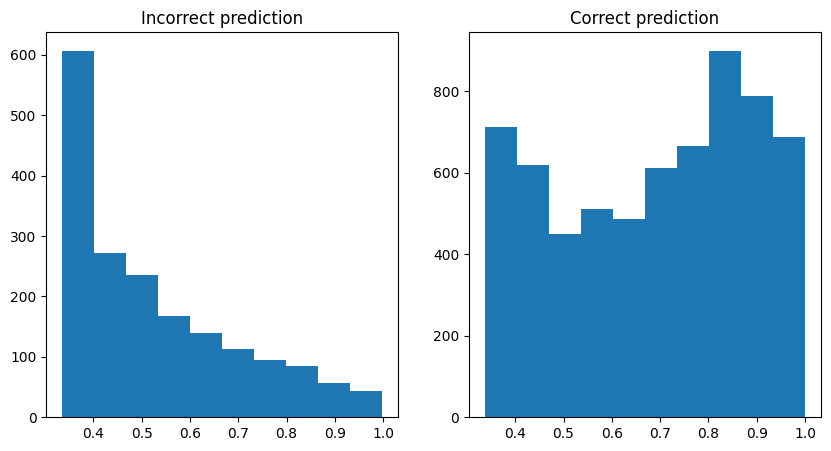

In [44]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(pred_test[pred_test['sentiment']!=pred_test['pred_class']]['max_proba'])
ax[0].set_title('Incorrect prediction')
ax[1].hist(pred_test[pred_test['sentiment']==pred_test['pred_class']]['max_proba'])
ax[1].set_title('Correct prediction')
fig.show()

Значення метрики f1 на тестових даних 67,5%. Модель не дуже точна. З матриці видно, що модель багато зразків невірно відносить до нейтрального класу. З графіків розподілу ймовірностей видно, що на неправильно передбачених зразках модель не дуже впевнена і багато ймовірностей лежить в діапазоні 0.34-0.5, тоді як менше значень в дапазоні 0.7-1.0. Хоча і серед правильних передбачень велика к-сть зразків з ймовірністю до 0.5.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [45]:
feat_importance=pd.DataFrame(logreg.coef_[0], index=vectorizer.get_feature_names_out(), columns=['imp'])

In [46]:
valuable_words=pd.concat([pd.DataFrame(feat_importance.sort_values(by='imp', ascending=True)[:30]).reset_index(drop=False),
                            pd.DataFrame(feat_importance.sort_values(by='imp', ascending=False)[:30]).reset_index(drop=False)], axis=1)

In [47]:
valuable_words

,index,imp,index,imp
0,love,-1.282643,miss,1.437311
1,thank,-1.080475,sad,1.397621
2,happi,-0.892397,sorri,1.201594
3,hope,-0.881329,suck,1.194920
4,good,-0.831158,hate,1.158894
5,great,-0.794138,bore,0.994084
6,awesom,-0.782978,bad,0.978682
7,nice,-0.690693,hurt,0.943661
8,lol,-0.648076,sick,0.930530
9,better,-0.538512,tire,0.768555


Загалом, перелік важливих слів виглядає логічно.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [73]:
english_stopwords=[i for i in english_stopwords if i not in ["aren't",'couldn',
 "couldn't",'didn',
 "didn't", 'doesn',
 "doesn't",'don',
 "don't",'hadn',
 "hadn't",'hasn',
 "hasn't",'haven',
 "haven't", 'isn',
 "isn't",'mightn',
 "mightn't",'needn',
 "needn't",'no',
 'not','shan',
 "shan't",'shouldn',
 "shouldn't",'wasn',
 "wasn't",'weren',
 "weren't","won't",
 'wouldn',
 "wouldn't",]]

In [127]:
tfidf=TfidfVectorizer(lowercase=True,
                           tokenizer=tokenize,
                           stop_words=english_stopwords,
                           max_features=5000)

In [107]:
tfidf.fit(df['selected_text'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'must', "n't"] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=1000,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', 'as', 'at', 'be', 'because', 'been',
                            'before', 'being', 'below', 'between', 'both',
                            'but', 'by', 'can', 'd', 'did', 'do', ...],
                tokenizer=<function tokenize at 0x7b77bb014040>)

In [108]:
input_tfidf=tfidf.transform(df['selected_text'])
# X_test_tfidf=tfidf.transform(X_test_tfidf)

In [109]:
X_train_tfidf=input_tfidf[train_idx]
X_test_tfidf=input_tfidf[test_idx]

In [111]:
logreg=LogisticRegression(solver='saga', penalty='l1')

In [112]:
logreg.fit(X_train_tfidf, y_train)
pred_tfidf=logreg.predict(X_test_tfidf)
proba_tfidf=logreg.predict_proba(X_test_tfidf)

In [113]:
accuracy_score(y_test, pred_tfidf)

0.8071324599708879

In [114]:
f1_score(y_test, pred_tfidf, average='weighted')

0.8076092116446733

In [116]:
confusion_matrix(y_test, pred_tfidf)

array([[1854,  404,   98],
       [ 348, 2788,  207],
       [ 272,  261, 2012]])

In [117]:
feat_importance=pd.DataFrame(logreg.coef_[0], index=tfidf.get_feature_names_out(), columns=['imp'])

In [118]:
feat_importance.loc[list(tfidf.get_feature_names_out()[:30])]

,imp
!,-0.744006
#,0.000000
$,0.000000
%,0.000000
&,0.000000
',0.000000
(,0.000000
),-2.740669
*,0.709665
+,0.000000


In [119]:
list(tfidf.get_feature_names_out()[:30])

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '--',
 '.',
 '..',
 '...',
 '....',
 '.....',
 '......',
 '.......',
 '.i',
 '/',
 '1',
 '10',
 '100',
 '11',
 '12',
 '15',
 '1st',
 '2']

In [120]:
valuable_words=pd.concat([pd.DataFrame(feat_importance.sort_values(by='imp', ascending=True)[:30]).reset_index(drop=False),
                            pd.DataFrame(feat_importance.sort_values(by='imp', ascending=False)[:30]).reset_index(drop=False)], axis=1)

In [121]:
valuable_words.columns=['pos_words', 'min_imp', 'neg_words', 'max_imp']

In [122]:
valuable_words

,pos_words,min_imp,neg_words,max_imp
0,lol,-5.901896,worst,4.869138
1,awesom,-5.562792,suck,4.599341
2,haha,-4.726669,stupid,4.577650
3,hope,-4.456995,fail,4.506158
4,thank,-4.026821,wtf,4.177718
5,love,-3.977253,sad,4.154343
6,final,-3.694703,wors,4.055018
7,glad,-3.626751,hate,3.863560
8,better,-3.444365,bore,3.821759
9,star,-3.347011,miss,3.798982


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [123]:
pred_test=pd.concat([y_test.reset_index(drop=True), pd.Series(pred_tfidf, name='pred_class'), pd.DataFrame(logreg.predict_proba(X_test_tfidf), columns=['neg', 'neutr', 'pos']),
                      pd.Series(np.max(logreg.predict_proba(X_test_tfidf), axis=1), name='max_proba')], axis=1)

In [124]:
predictions=pd.concat([df[['selected_text','text']].iloc[test_idx,:].reset_index(drop=True), pred_test], axis=1)

In [125]:
predictions[predictions['sentiment']!=predictions['pred_class']]

,selected_text,text,sentiment,pred_class,neg,neutr,pos,max_proba
1,kinda turns me off,--of them kinda turns me off of it all. And ...,negative,neutral,0.314567,0.449719,0.235714,0.449719
7,t I have an exam on the monday that Im gonna fail,"Ooooh, I`m jealous I might try and get some ...",negative,neutral,0.337082,0.641748,0.021169,0.641748
9,wee. done with advance audit paper,wee. done with advance audit paper,neutral,positive,0.213418,0.328847,0.457736,0.457736
17,What a miserable day,At work... What a miserable day,negative,neutral,0.256991,0.385414,0.357595,0.385414
21,I wish I had company,I wish I had company,negative,positive,0.153882,0.274262,0.571856,0.571856
...,...,...,...,...,...,...,...,...
8218,please don`t,please don`t,neutral,negative,0.548171,0.271284,0.180545,0.548171
8222,"boredd,","juss boredd, !",negative,neutral,0.236306,0.573591,0.190103,0.573591
8234,Greenville Drive games just aren`t the same wi...,Greenville Drive games just aren`t the same wi...,negative,neutral,0.170105,0.777485,0.052409,0.777485
8236,Foto!,Foto!,neutral,positive,0.263574,0.320811,0.415615,0.415615


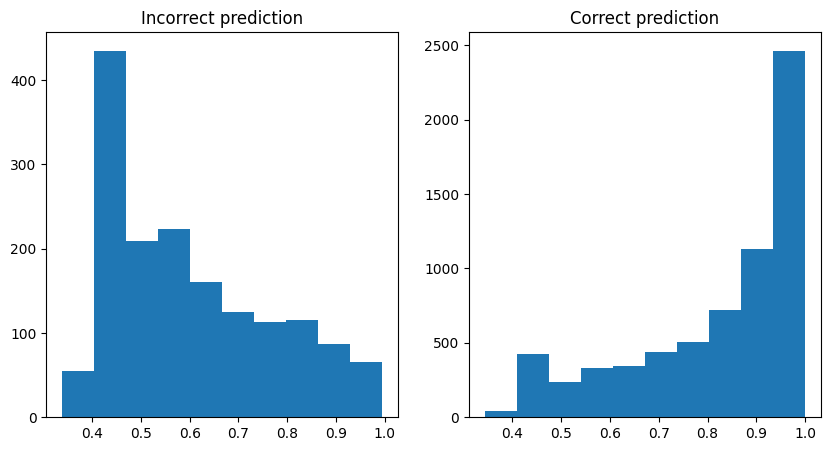

In [126]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(pred_test[pred_test['sentiment']!=pred_test['pred_class']]['max_proba'])
ax[0].set_title('Incorrect prediction')
ax[1].hist(pred_test[pred_test['sentiment']==pred_test['pred_class']]['max_proba'])
ax[1].set_title('Correct prediction')
fig.show()

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model